# Genarate Data

In [7]:
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta
import os

# -----------------------------
# Helper function to create path
def mkpath(name):
    os.makedirs("datasets", exist_ok=True)
    return f"datasets/{name}"

# -----------------------------
# Sri Lanka cities and conditions
cities = ["Colombo", "Galle", "Kandy", "Matara", "Kurunegala", "Anuradhapura", "Trincomalee", "Jaffna", "Batticaloa", "Ratnapura"]
road_types = ["city","highway","rural","coastal"]
weathers = ["sunny","cloudy","light_rain","heavy_rain","monsoon"]
time_of_day_buckets = ["morning","afternoon","evening","night"]

# Vehicle models
vehicle_models = [
    {"make":"Nissan", "model":"Leaf", "eff_kwh_per_km":0.16, "weight_kg":1500},
    {"make":"MG", "model":"ZS EV", "eff_kwh_per_km":0.18, "weight_kg":1650},
    {"make":"BYD", "model":"Atto 3", "eff_kwh_per_km":0.17, "weight_kg":1700},
    {"make":"Tesla", "model":"Model 3", "eff_kwh_per_km":0.15, "weight_kg":1620},
]

# Charging stations
charging_stations = []
station_types = ["AC_7kW","AC_22kW","DC_50kW","DC_120kW"]
for i, city in enumerate(cities, start=1):
    for j in range(3):
        charging_stations.append({
            "station_id": f"CS_{i:02d}_{j+1}",
            "name": f"ChargePoint {city} #{j+1}",
            "city": city,
            "charger_type": random.choice(station_types),
            "num_ports": random.choice([1,2,3]),
            "avg_wait_min": random.randint(0,30),
            "operational": random.choices([True, False], weights=[0.95,0.05])[0]
        })
charging_stations_df = pd.DataFrame(charging_stations)

# -----------------------------
# Helper for origin-destination sampling
def sample_od():
    o = random.choice(cities)
    d = random.choice([c for c in cities if c != o])
    idx_o = cities.index(o)
    idx_d = cities.index(d)
    base = abs(idx_o - idx_d) * 40 + 20
    distance = max(5, int(np.random.normal(base, base * 0.25)))
    elev_gain = int(abs(idx_o - idx_d) * random.uniform(10,50) + (50 if ("Kandy" in (o,d) or "Ratnapura" in (o,d)) else 0))
    return o, d, distance, elev_gain

# -----------------------------
N_TRIPS = 50000  # number of synthetic trips

# 1) Driving Style Dataset
driving_rows = []
for tid in range(N_TRIPS):
    trip_id = f"TR{tid+1:06d}"
    driver_id = f"DRV{random.randint(1,400):04d}"
    vehicle = random.choice(vehicle_models)
    origin, dest, distance_km, elev_gain_m = sample_od()
    trip_duration_min = max(3, int(distance_km / max(10, np.random.normal(45,10)) * 60))
    avg_speed = round(distance_km / (trip_duration_min/60.0) + np.random.normal(0,3), 2)
    max_speed = round(avg_speed + abs(np.random.normal(10,7)), 2)
    style_latent = random.choices(["eco","normal","aggressive"], weights=[0.25,0.6,0.15])[0]
    if style_latent == "eco":
        accel_mean = round(np.random.normal(0.45, 0.05),3) # Reduced noise
        accel_std = round(abs(np.random.normal(0.15,0.05)),3) # Reduced noise
        braking_intensity = round(abs(np.random.normal(0.15,0.05)),3) # Reduced noise
    elif style_latent == "normal":
        accel_mean = round(np.random.normal(0.9, 0.1),3) # Reduced noise
        accel_std = round(abs(np.random.normal(0.4,0.1)),3) # Reduced noise
        braking_intensity = round(abs(np.random.normal(0.3,0.1)),3) # Reduced noise
    else:
        accel_mean = round(np.random.normal(1.8, 0.2),3) # Reduced noise
        accel_std = round(abs(np.random.normal(0.8,0.2)),3) # Reduced noise
        braking_intensity = round(abs(np.random.normal(0.8,0.2)),3) # Reduced noise
    road_type = random.choice(road_types)
    weather = random.choices(weathers, weights=[0.35,0.25,0.15,0.15,0.10])[0]
    time_of_day = random.choice(time_of_day_buckets)
    # label based on simple heuristic
    if accel_mean < 0.6 and accel_std < 0.5 and braking_intensity < 0.4:
        style_label = "Eco"
    elif accel_mean > 1.4 or accel_std > 1.0 or braking_intensity > 0.9:
        style_label = "Aggressive"
    else:
        style_label = "Normal"
    driving_rows.append({
        "trip_id": trip_id, "driver_id": driver_id, "vehicle_make": vehicle["make"], "vehicle_model": vehicle["model"],
        "origin": origin, "destination": dest, "distance_km": distance_km, "elevation_gain_m": elev_gain_m,
        "trip_date": (datetime.now() - timedelta(days=random.randint(0,365))).strftime("%Y-%m-%d %H:%M:%S"),
        "avg_speed": max(0.0, round(avg_speed,2)), "max_speed": max(0.0, round(max_speed,2)),
        "acceleration_mean": max(0.0, accel_mean), "acceleration_std": accel_std, "braking_intensity": braking_intensity,
        "trip_duration_min": trip_duration_min, "road_type": road_type, "weather": weather,
        "time_of_day": time_of_day, "driving_style": style_label
    })
driving_df = pd.DataFrame(driving_rows)
driving_df.to_csv(mkpath("driving_style_dataset_srilanka.csv"), index=False)

# 2) Energy Consumption Dataset
energy_rows = []
for _, row in driving_df.iterrows():
    vehicle = next(v for v in vehicle_models if v["model"] == row["vehicle_model"])
    base_eff = vehicle["eff_kwh_per_km"]
    # Slightly simplified multipliers for potentially clearer relationships
    style_mult = {"Eco":0.9, "Normal":1.0, "Aggressive":1.2}[row["driving_style"]] # Reduced aggressive impact
    traffic_mult = {"city":1.03, "highway":0.97, "rural":1.0, "coastal":1.01}[row["road_type"]] # Reduced variation
    weather_mult = {"sunny":1.0, "cloudy":1.01, "light_rain":1.02, "heavy_rain":1.05, "monsoon":1.08}[row["weather"]] # Reduced variation
    elev_factor = 1 + (row["elevation_gain_m"] / (row["distance_km"]*100+1))*0.5 # Reduced elevation impact
    noise = np.random.normal(0,0.005) # Significantly reduced noise
    energy_kwh = row["distance_km"] * base_eff * style_mult * traffic_mult * weather_mult * elev_factor * (1+noise)
    battery_capacity = random.choice([40,50,60,75])
    battery_start_pct = round(random.uniform(40,100),2)
    battery_start_kwh = battery_capacity * battery_start_pct / 100
    battery_end_kwh = max(0, battery_start_kwh - energy_kwh)
    battery_end_pct = round(battery_end_kwh / battery_capacity * 100,2)
    energy_rows.append({
        "trip_id": row["trip_id"], "vehicle_model": row["vehicle_model"], "distance_km": row["distance_km"],
        "driving_style": row["driving_style"], "road_type": row["road_type"], "weather": row["weather"],
        "elevation_gain_m": row["elevation_gain_m"], "avg_speed": row["avg_speed"],
        "energy_consumed_kWh": round(max(0.01, energy_kwh),3),
        "battery_capacity_kWh": battery_capacity, "battery_start_%": battery_start_pct, "battery_end_%": battery_end_pct
    })
energy_df = pd.DataFrame(energy_rows)
energy_df.to_csv(mkpath("energy_consumption_dataset_srilanka.csv"), index=False)

# 3) Battery Range Dataset
range_rows = []
for _, e in energy_df.iterrows():
    vehicle = next(v for v in vehicle_models if v["model"]==e["vehicle_model"])
    style_eff_mult = {"Eco":0.98,"Normal":1.0,"Aggressive":1.1}[e["driving_style"]] # Reduced variation
    eff = vehicle["eff_kwh_per_km"]*style_eff_mult
    start_kwh = e["battery_capacity_kWh"]*e["battery_start_%"]/100
    max_possible_km = round(start_kwh / eff,2)
    predicted_remaining_km = max(0, round((start_kwh - e["energy_consumed_kWh"]) / eff,2))
    range_rows.append({
        "trip_id": e["trip_id"], "vehicle_model": e["vehicle_model"], "battery_capacity_kWh": e["battery_capacity_kWh"],
        "battery_start_%": e["battery_start_%"], "battery_start_kWh": round(start_kwh,3),
        "eff_kWh_per_km": round(eff,4), "max_possible_km": max_possible_km, "predicted_remaining_km": predicted_remaining_km
    })
range_df = pd.DataFrame(range_rows)
range_df.to_csv(mkpath("battery_range_dataset_srilanka.csv"), index=False)

# 4) Charging Station Recommender Dataset
charge_rows = []
for _, row in driving_df.iterrows():
    origin, dest = row["origin"], row["destination"]
    candidates = [s for s in charging_stations if s["city"] in {origin,dest}]
    if len(candidates)<3:
        intermediate = random.choice([c for c in cities if c not in {origin,dest}])
        candidates += [s for s in charging_stations if s["city"]==intermediate]
    sample_cands = random.sample(candidates, min(3,len(candidates)))
    best_score = 1e9
    best_station = None
    for s in sample_cands:
        base = 5 if s["city"] in {origin,dest} else random.randint(10,60)
        power_factor = 0.8 if "DC" in s["charger_type"] else 1.0
        avail = 1 if s["operational"] else 0.01
        score = base*power_factor/(avail+0.001) + s["avg_wait_min"]*0.1
        if score<best_score:
            best_score = score
            best_station = s
        charge_rows.append({
            "trip_id": row["trip_id"], "station_id": s["station_id"], "station_name": s["name"], "station_city": s["city"],
            "charger_type": s["charger_type"], "num_ports": s["num_ports"], "avg_wait_min": s["avg_wait_min"],
            "operational": s["operational"], "distance_from_route_km": base, "is_recommended": int(s["station_id"]==best_station["station_id"])
        })
charge_df = pd.DataFrame(charge_rows)
charge_df.to_csv(mkpath("charging_recommender_dataset_srilanka.csv"), index=False)

# 5) Optimal Route Dataset
route_rows = []
for tid in range(1000):
    origin = random.choice(cities)
    dest = random.choice([c for c in cities if c!=origin])
    base_distance = random.randint(20,120)
    routes = []
    for r in ["A","B","C"]:
        route_distance = max(5,int(base_distance*random.uniform(0.85,1.15))) # Reduced variation
        avg_speed = max(30,int(np.random.normal(60,8))) # Increased base speed, reduced variation
        traffic_level = random.choice(["low","medium","high"])
        time_min = int(route_distance/max(10,avg_speed)*60*(1 + (0.15 if traffic_level=="high" else 0.03 if traffic_level=="medium" else 0))) # Reduced traffic impact
        veh = random.choice(vehicle_models)
        style = random.choices(["Eco","Normal","Aggressive"], weights=[0.3,0.5,0.2])[0] # Slightly adjusted style distribution
        weather = random.choice(weathers)
        style_mult = {"Eco":0.95,"Normal":1.0,"Aggressive":1.1}[style] # Reduced variation
        weather_mult = {"sunny":1.0,"cloudy":1.01,"light_rain":1.02,"heavy_rain":1.04,"monsoon":1.06}[weather] # Reduced variation
        energy_est = route_distance*veh["eff_kwh_per_km"]*style_mult*weather_mult
        routes.append({
            "route_label": r, "route_distance_km": route_distance, "avg_speed_kmh": avg_speed,
            "traffic_level": traffic_level, "estimated_time_min": time_min,
            "estimated_energy_kWh": round(energy_est,3), "driving_style": style,
            "vehicle_model": veh["model"], "weather": weather
        })
    best = min(routes, key=lambda x: 0.6*x["estimated_energy_kWh"] + 0.4*(x["estimated_time_min"]/60.0)) # Adjusted weighting
    for r in routes:
        route_rows.append({
            "origin": origin, "destination": dest, "route_id": f"{origin}_{dest}_{r['route_label']}",
            **r, "is_optimal": int(r["route_label"]==best["route_label"])
        })
route_df = pd.DataFrame(route_rows)
route_df.to_csv(mkpath("optimal_route_dataset_srilanka.csv"), index=False)

# Charging stations master CSV
charging_stations_df.to_csv(mkpath("charging_stations_master_srilanka.csv"), index=False)

print("Datasets generated in ./datasets folder!")

Datasets generated in ./datasets folder!


#Check Best Model Function

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, r2_score
from sklearn.pipeline import Pipeline

# Classification algorithms
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Regression algorithms
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor


def find_best_algorithm(dataset_path, problem_type="classification", target_column=None):
    """
    Evaluate multiple ML algorithms (classification or regression)
    and return the best one with its score.
    """
    df = pd.read_csv(dataset_path)

    # Auto-detect target column
    if target_column is None:
        target_column = df.columns[-1]
        print(f"[INFO] Target column guessed as '{target_column}'")

    # Split features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Encode categorical variables
    for col in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

    if y.dtype == 'object':
        y = LabelEncoder().fit_transform(y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define candidate models
    if problem_type.lower() == "classification":
        models = {
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "KNN": KNeighborsClassifier(),
            "SVM": SVC(),
            "Random Forest": RandomForestClassifier(),
            "Gradient Boosting": GradientBoostingClassifier(),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
        }
        metric_name = "Accuracy"
        metric_fn = accuracy_score
    else:  # regression
        models = {
            "Multiple Linear Regression": LinearRegression(),  # Explicit name for clarity
            "Lasso Regression": Lasso(),
            "Support Vector Regression (SVR)": SVR(),
            "Random Forest Regressor": RandomForestRegressor(),
            "Gradient Boosting Regressor": GradientBoostingRegressor(),
            "XGBoost Regressor": XGBRegressor()
        }
        metric_name = "R² Score"
        metric_fn = r2_score

    # Evaluate models
    results = []
    best_model, best_score = None, -np.inf

    for name, model in models.items():
        pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
        pipe.fit(X_train, y_train)
        preds_test = pipe.predict(X_test)
        preds_train = pipe.predict(X_train)

        # Choose metric
        score_test = metric_fn(y_test, preds_test)
        score_train = metric_fn(y_train, preds_train)
        results.append((name, score_train, score_test))

        if score_test > best_score:
            best_score = score_test
            best_model = name

    # Print results
    print("\n📊 Model Evaluation Results:")
    print(f"{'Model Name':<35} | {'Train Score':<15} | {'Test Score':<15}")
    print("-" * 68)
    for name, score_train, score_test in sorted(results, key=lambda x: x[2], reverse=True):
        print(f"{name:<35} | {score_train:<15.4f} | {score_test:<15.4f}")

    print(f"\n✅ Best Algorithm: **{best_model}** with {metric_name} = {best_score:.4f} on the test set.")
    return best_model, best_score

#battery_range_dataset_srilanka.csv


In [ ]:
# Use the find_best_algorithm function to evaluate regression models on the battery range dataset
find_best_algorithm(dataset_path=mkpath("battery_range_dataset_srilanka.csv"),
                    problem_type="regression",
                    target_column="predicted_remaining_km")

## Load the dataset

### Subtask:
Load the `battery_range_dataset_srilanka.csv` file into a pandas DataFrame.


**Reasoning**:
The subtask is to load the dataset and display its head and info, so I will use `pd.read_csv` and then display the head and info of the dataframe.



In [9]:
battery_range_df = pd.read_csv(mkpath("battery_range_dataset_srilanka.csv"))
display(battery_range_df.head())
display(battery_range_df.info())

,trip_id,vehicle_model,battery_capacity_kWh,battery_start_%,battery_start_kWh,eff_kWh_per_km,max_possible_km,predicted_remaining_km
0,TR000001,Atto 3,60,62.75,37.650,0.1700,221.47,2.41
1,TR000002,Atto 3,60,64.82,38.892,0.1700,228.78,28.82
2,TR000003,Model 3,50,88.45,44.225,0.1500,294.83,173.06
3,TR000004,Atto 3,50,45.90,22.950,0.1666,137.76,0.00
4,TR000005,Model 3,40,46.83,18.732,0.1470,127.43,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trip_id                 50000 non-null  object 
 1   vehicle_model           50000 non-null  object 
 2   battery_capacity_kWh    50000 non-null  int64  
 3   battery_start_%         50000 non-null  float64
 4   battery_start_kWh       50000 non-null  float64
 5   eff_kWh_per_km          50000 non-null  float64
 6   max_possible_km         50000 non-null  float64
 7   predicted_remaining_km  50000 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


None

## Identify numerical columns

### Subtask:
Determine which columns in the DataFrame contain numerical data, as outlier detection is typically performed on numerical features.


**Reasoning**:
Identify numerical columns in the DataFrame to prepare for outlier detection.



In [10]:
numerical_cols = battery_range_df.select_dtypes(include=np.number).columns.tolist()
print("Numerical columns:", numerical_cols)

Numerical columns: ['battery_capacity_kWh', 'battery_start_%', 'battery_start_kWh', 'eff_kWh_per_km', 'max_possible_km', 'predicted_remaining_km']


## Visualize outliers

### Subtask:
Generate box plots for the numerical columns to visually identify potential outliers.

**Reasoning**:
Generate box plots for each numerical column to visualize the distribution and identify potential outliers. Using `matplotlib.pyplot` and iterating through the `numerical_cols` list, I will create a box plot for each column.

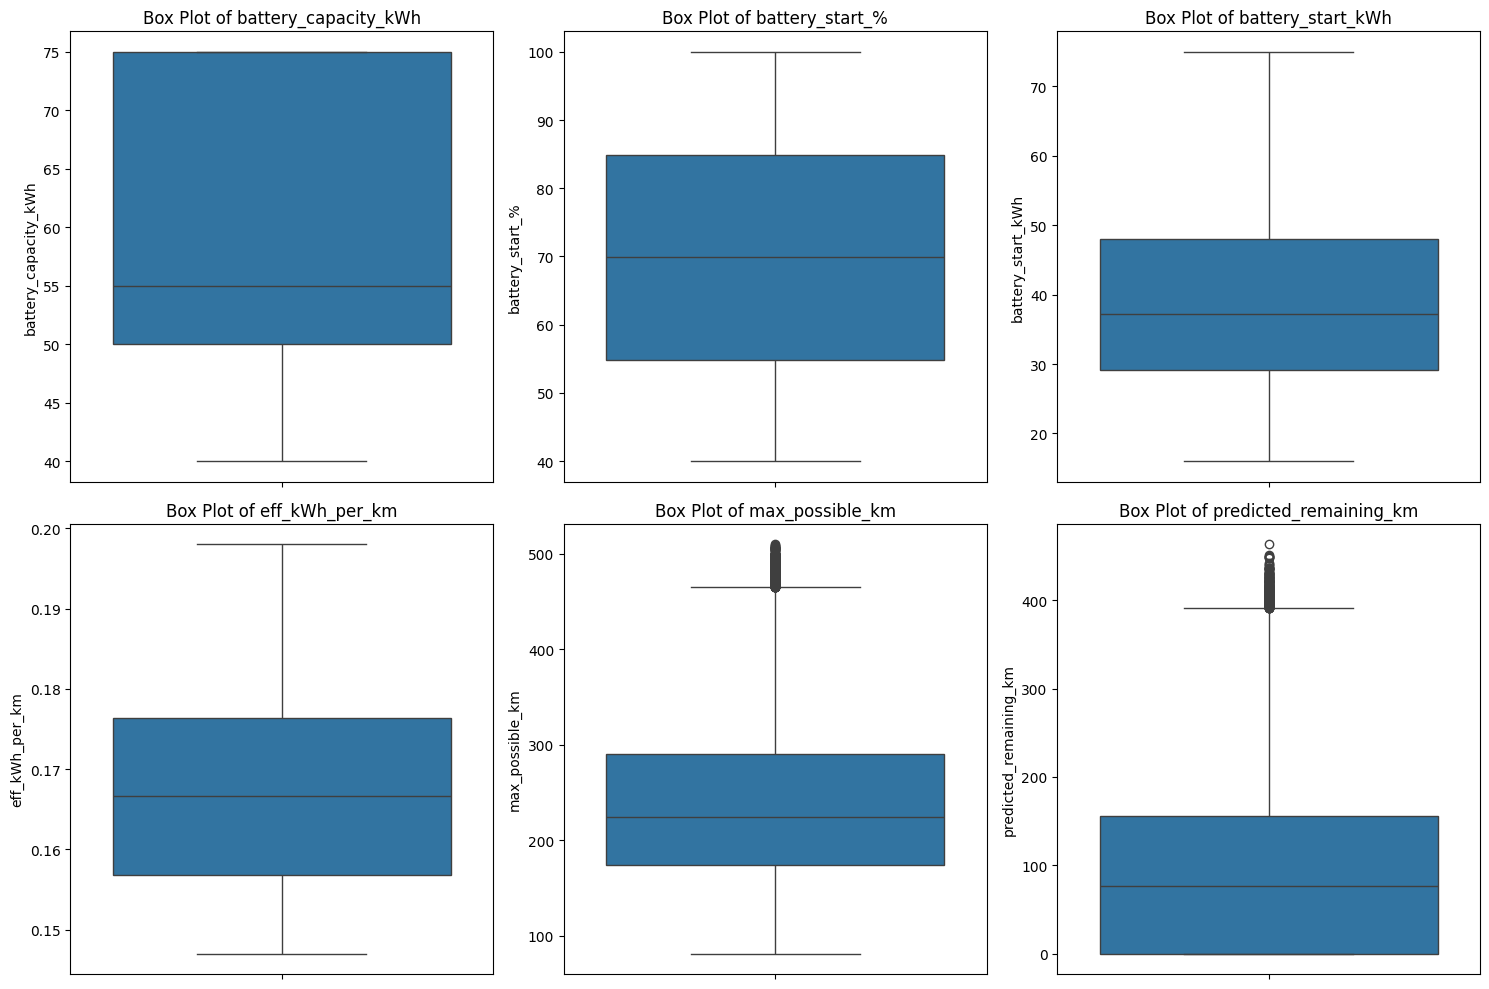

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate box plots for numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=battery_range_df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

## Cap outliers using winsorization

### Subtask:
Apply Winsorization to the numerical columns of the `battery_range_dataset_srilanka.csv` DataFrame to cap the outliers.


**Reasoning**:
Apply Winsorization to the numerical columns of the DataFrame to cap the outliers using the specified limits.



In [12]:
from scipy.stats.mstats import winsorize

for col in numerical_cols:
    battery_range_df[col] = winsorize(battery_range_df[col], limits=[0.05, 0.05])

display(battery_range_df.head())
display(battery_range_df.describe())

,trip_id,vehicle_model,battery_capacity_kWh,battery_start_%,battery_start_kWh,eff_kWh_per_km,max_possible_km,predicted_remaining_km
0,TR000001,Atto 3,60,62.75,37.650,0.1700,221.47,2.41
1,TR000002,Atto 3,60,64.82,38.892,0.1700,228.78,28.82
2,TR000003,Model 3,50,88.45,44.225,0.1500,294.83,173.06
3,TR000004,Atto 3,50,45.90,22.950,0.1666,137.76,0.00
4,TR000005,Model 3,40,46.83,20.460,0.1470,127.43,0.00


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask'

,battery_capacity_kWh,battery_start_%,battery_start_kWh,eff_kWh_per_km,max_possible_km,predicted_remaining_km
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,56.29730,69.859674,39.223941,0.166257,236.254550,92.875343
std,12.93545,17.066508,12.863422,0.012094,78.599771,89.385786
min,40.00000,42.960000,20.460000,0.147000,120.980000,0.000000
25%,50.00000,54.810000,29.079000,0.156800,173.867500,0.000000
50%,55.00000,69.945000,37.242000,0.166600,224.200000,76.070000
75%,75.00000,84.820000,48.023000,0.176400,290.200000,156.330000
max,75.00000,96.950000,65.985000,0.187000,397.760000,280.560000


**Reasoning**:
The outliers have been capped using Winsorization, and the next step is to save the modified dataset to a new CSV file.



In [13]:
battery_range_df.to_csv(mkpath("battery_range_dataset_srilanka_winsorized.csv"), index=False)

## train models

### Subtask:
Use the `find_best_algorithm` function on the new dataset with capped outliers to evaluate and find the best regression model.


**Reasoning**:
Call the `find_best_algorithm` function with the path to the winsorized dataset, specifying the problem type as regression and the target column.



In [14]:
find_best_algorithm(dataset_path=mkpath("battery_range_dataset_srilanka_winsorized.csv"),
                    problem_type="regression",
                    target_column="predicted_remaining_km")


📊 Model Evaluation Results:
Model Name                          | Train Score     | Test Score     
--------------------------------------------------------------------
Gradient Boosting Regressor         | 0.4842          | 0.4561         
Multiple Linear Regression          | 0.4705          | 0.4526         
Lasso Regression                    | 0.4690          | 0.4518         
XGBoost Regressor                   | 0.5920          | 0.4331         
Support Vector Regression (SVR)     | 0.4436          | 0.4192         
Random Forest Regressor             | 0.9171          | 0.3921         

✅ Best Algorithm: **Gradient Boosting Regressor** with R² Score = 0.4561 on the test set.


('Gradient Boosting Regressor', 0.4561403871290416)

## Visualize outliers after Winsorization

### Subtask:
Generate box plots for the numerical columns of the Winsorized DataFrame to visually assess the impact of outlier capping.

**Reasoning**:
Generate box plots for each numerical column of the winsorized DataFrame to visualize the distribution and confirm that the outliers have been capped. Using `matplotlib.pyplot` and iterating through the `numerical_cols` list, I will create a box plot for each column using the `battery_range_df` which has been modified with Winsorization.

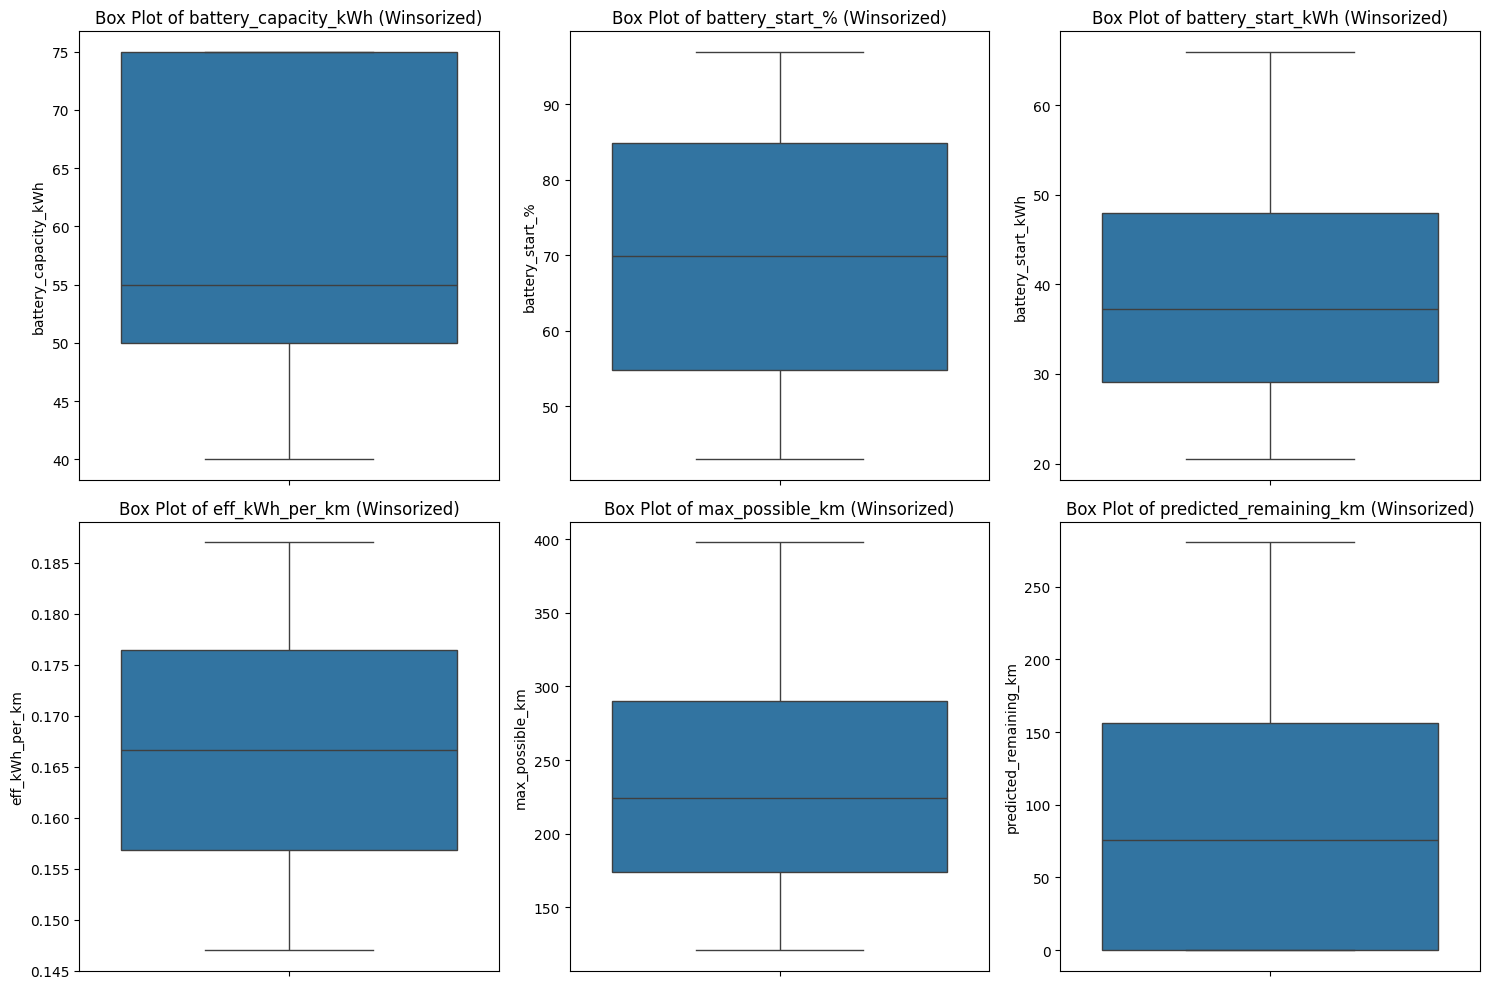

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate box plots for numerical columns after Winsorization
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=battery_range_df[col])
    plt.title(f'Box Plot of {col} (Winsorized)')
plt.tight_layout()
plt.show()

## Load the winsorized dataset

### Subtask:
Load the `battery_range_dataset_srilanka_winsorized.csv` file into a pandas DataFrame.


**Reasoning**:
Load the winsorized dataset into a pandas DataFrame and display the head and info to confirm it loaded correctly.



In [16]:
winsorized_battery_range_df = pd.read_csv(mkpath("battery_range_dataset_srilanka_winsorized.csv"))
display(winsorized_battery_range_df.head())
display(winsorized_battery_range_df.info())

,trip_id,vehicle_model,battery_capacity_kWh,battery_start_%,battery_start_kWh,eff_kWh_per_km,max_possible_km,predicted_remaining_km
0,TR000001,Atto 3,60,62.75,37.650,0.1700,221.47,2.41
1,TR000002,Atto 3,60,64.82,38.892,0.1700,228.78,28.82
2,TR000003,Model 3,50,88.45,44.225,0.1500,294.83,173.06
3,TR000004,Atto 3,50,45.90,22.950,0.1666,137.76,0.00
4,TR000005,Model 3,40,46.83,20.460,0.1470,127.43,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trip_id                 50000 non-null  object 
 1   vehicle_model           50000 non-null  object 
 2   battery_capacity_kWh    50000 non-null  int64  
 3   battery_start_%         50000 non-null  float64
 4   battery_start_kWh       50000 non-null  float64
 5   eff_kWh_per_km          50000 non-null  float64
 6   max_possible_km         50000 non-null  float64
 7   predicted_remaining_km  50000 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


None

## Prepare data

### Subtask:
Separate features (X) and target (y), encode categorical variables, and split the data into training and testing sets.


**Reasoning**:
Separate features (X) and target (y), encode categorical variables using one-hot encoding, and split the data into training and testing sets as per the instructions.



In [17]:
y = winsorized_battery_range_df['predicted_remaining_km']
X = winsorized_battery_range_df.drop(columns=['predicted_remaining_km', 'trip_id', 'battery_start_kWh'])

categorical_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (40000, 7)
Shape of X_test: (10000, 7)
Shape of y_train: (40000,)
Shape of y_test: (10000,)


## Scale numerical features

### Subtask:
Apply StandardScaler to the numerical features in the training and testing sets.


**Reasoning**:
Apply StandardScaler to the numerical features in the training and testing sets.



In [18]:
from sklearn.preprocessing import StandardScaler

numerical_cols_to_scale = ['battery_capacity_kWh', 'battery_start_%', 'eff_kWh_per_km', 'max_possible_km']

scaler = StandardScaler()

X_train[numerical_cols_to_scale] = scaler.fit_transform(X_train[numerical_cols_to_scale])
X_test[numerical_cols_to_scale] = scaler.transform(X_test[numerical_cols_to_scale])

display(X_train.head())
display(X_test.head())

,battery_capacity_kWh,battery_start_%,eff_kWh_per_km,max_possible_km,vehicle_model_Leaf,vehicle_model_Model 3,vehicle_model_ZS EV
39087,0.282808,0.961910,1.715787,0.318077,False,False,True
30893,-0.489549,0.062281,-1.590741,0.061124,False,True,False
45278,0.282808,-0.465432,1.137145,-0.381872,False,False,True
16398,-0.489549,-0.218853,0.310513,-0.533223,False,False,False
13653,1.441345,1.137619,1.137145,1.723185,False,False,True


,battery_capacity_kWh,battery_start_%,eff_kWh_per_km,max_possible_km,vehicle_model_Leaf,vehicle_model_Model 3,vehicle_model_ZS EV
33553,1.441345,-0.034945,-0.102803,0.996677,False,True,False
9427,-0.489549,0.874055,1.715787,-0.124030,False,False,False
199,-1.261907,0.189377,0.029458,-0.774672,False,False,False
12447,1.441345,-1.577083,-0.516119,-0.613410,True,False,False
39489,-0.489549,0.541966,0.029458,0.012707,False,False,False


**Reasoning**:
Train a Gradient Boosting Regressor model on the scaled training data and evaluate its performance on the scaled test data.



In [19]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"R² score of Gradient Boosting Regressor on winsorized data: {r2:.4f}")

R² score of Gradient Boosting Regressor on winsorized data: 0.4561


In [26]:
import pandas as pd

# Provided new data
new_data = pd.DataFrame({
    'battery_capacity_kWh': [60],
    'battery_start_%': [75],
    'eff_kWh_per_km': [0.17],
    'max_possible_km': [250],
    'vehicle_model': ['Leaf']
})

# Apply one-hot encoding to the new data, aligning columns with the original training data (X_train)
new_data_encoded = pd.get_dummies(new_data, columns=['vehicle_model'])

# Ensure new data has the same columns as X_train, adding missing columns with 0
missing_cols = set(X_train.columns) - set(new_data_encoded.columns)
for c in missing_cols:
    new_data_encoded[c] = 0

# Ensure the order of columns is the same as X_train
new_data_encoded = new_data_encoded[X_train.columns]

# Scale the numerical features of the new data using the original fitted scaler
numerical_cols_to_scale = ['battery_capacity_kWh', 'battery_start_%', 'eff_kWh_per_km', 'max_possible_km']
new_data_scaled = new_data_encoded.copy()
new_data_scaled[numerical_cols_to_scale] = scaler.transform(new_data_scaled[numerical_cols_to_scale])

# Predict remaining KM using the first trained model (gbr)
predicted_remaining_km_single = gbr.predict(new_data_scaled)

# Print the prediction
print("Predicted remaining KM for the input data:")
print(predicted_remaining_km_single[0])

Predicted remaining KM for the input data:
96.97596047801086


## Visualize Distribution of Predicted Remaining KM

### Subtask:
Visualize the distribution of the predicted remaining kilometers using a histogram.

**Reasoning**:
Generate a histogram of the `y_pred` array to visualize the distribution of the predicted remaining kilometers.

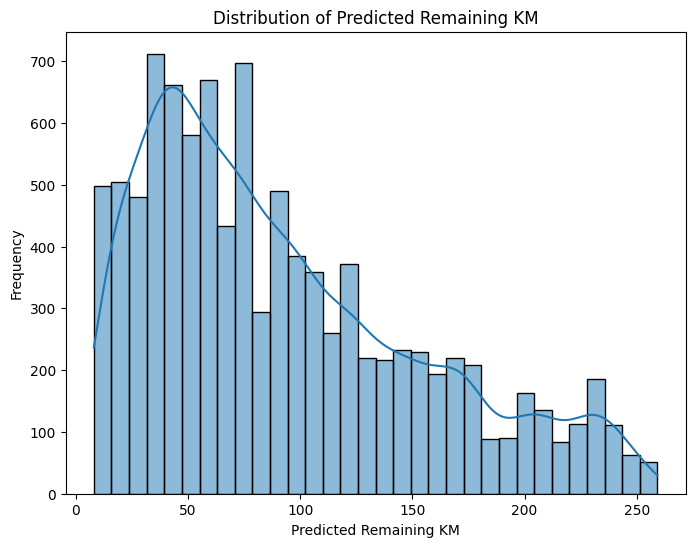

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(y_pred, kde=True)
plt.title('Distribution of Predicted Remaining KM')
plt.xlabel('Predicted Remaining KM')
plt.ylabel('Frequency')
plt.show()

In [32]:
import pickle
import os

# Create a directory to save the model if it doesn't exist
os.makedirs("models", exist_ok=True)

# Define the path to save the model
model_path = "models/Predicted_remaining_KM_model.pkl"

# Save the trained model to a .pkl file
with open(model_path, 'wb') as f:
    pickle.dump(gbr, f)

print(f"Gradient Boosting Regressor model saved to: {model_path}")

Gradient Boosting Regressor model saved to: models/Predicted_remaining_KM_model.pkl


In [33]:
import google.colab.files
import os

# List files in the 'models' directory to confirm the filename
!ls models

# Specify the path to the model file
model_path = "models/Predicted_remaining_KM_model.pkl"

# Check if the file exists before attempting to download
if os.path.exists(model_path):
  google.colab.files.download(model_path)
else:
  print(f"File not found: {model_path}")

Predicted_remaining_KM_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>